In [1]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram
import copy, random, itertools
import qiskit.providers.aer.noise as noise
from qiskit.quantum_info.analysis import hellinger_fidelity


In [2]:
# parameters
noise = True
simulator = Aer.get_backend('qasm_simulator')
optimization_level = 2
shots = 8192
max_rounds = 500
verbose_flag = False

# number of generals
N_gen = 4

# here you can change the backends
from qiskit.test.mock import FakeSantiago as device_3_generals
from qiskit.test.mock import FakeMontreal as device_4_generals

In [3]:
# adapt to given parameters
if N_gen == 3:
    perms = list(itertools.permutations(['00','01','10'], r=3))
    device = device_3_generals
    
elif N_gen == 4:
    perms = list(itertools.permutations(['00','01','10','11'], r=4))
    device = device_4_generals
    
else: 
    print("only the three and four generals cases considered at this time")

if noise:
    backend = AerSimulator.from_backend(device())
else: # switch to the ideal device
    backend = simulator

In [4]:
# set device dependant parameter for final agreement algorithm
noise_dic = {'qasm_simulator' : 0.49,
             'aer_simulator(fake_santiago)' : 0.25,
             'aer_simulator(fake_montreal)' : 0.175,
             'aer_simulator(fake_mumbai)' : 0.25,
             'aer_simulator(fake_quito)' : 0.1, 
             'aer_simulator(fake_casablanca)' : 0.15, 
             'aer_simulator(fake_guadalupe)' : 0.1,
             'aer_simulator(fake_sydney)' : 0.15,
            }

In [5]:
# use the simulator to get get the bitstring list
circuit = QuantumCircuit(N_gen+1)
circuit.h(circuit.qubits)

circuit.measure_active()

job = execute(circuit, backend = simulator,shots = 2**13)
              
result = job.result()
counts = result.get_counts(circuit)

bitstrings = np.sort(list(counts.keys()))

#### Prepare the state:


In case of three generals:

$$ \frac{1}{2\;\sqrt3}\; (\;2\;|0011\rangle - |0101\rangle - |0110\rangle - |1001\rangle -  |1010\rangle + 2\;|1100\rangle\;) $$


In case of four generals:


$$(3|00111\rangle -  |01001\rangle -  |01010\rangle - |01100\rangle - |10001 \rangle -  |10010\rangle -  |10100\rangle +  |11100\rangle) \ /\sqrt!4$$

In [6]:
if N_gen == 3:
    init_list = np.array([0., 0., 0., 2., 0., -1., -1., 0.,
             0., -1., -1., 0., 2., 0., 0., 0.]) / ( 2*np.sqrt(3) )
elif N_gen == 4:
    init_list = np.array(  [0., 0., 0., 0., 0., 0., 0., 3.,
                            0., -1., -1., 0., -1., 0., 0., 0.,
                            0., -1., -1., 0., -1., 0., 0., 0.,
                            #0., 0., 0., -1., 0., -1., -1., 0., (# possible variant for row 3)
                            3., 0., 0., 0., 0., 0., 0., 0.]) / ( 2*np.sqrt(6) )
else: 
    print("only the three and four generals cases considered at this time")

In [7]:
# create the quantum circuit
circuit = QuantumCircuit(N_gen+1)

circuit.initialize(init_list, circuit.qubits)

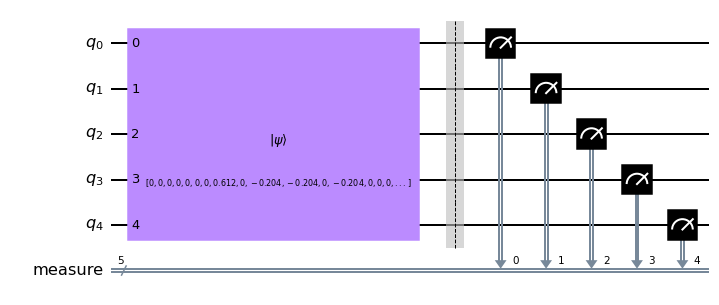

In [8]:
# add Pauli-Z measurements and draw the circuit
circuit.measure_active()
circuit.draw(output='mpl')

In [9]:
# if more details are requested (more .decompose() may be added)
#qasm_circuit = circuit.decompose().decompose() 
#qasm_circuit.draw(output='mpl', fold = 20 - N_gen , plot_barriers=False,
                  #style = {'backgroundcolor': 'cyan'})                                             

## game functions

In [10]:
# byzantine traitor game serving function
# byzantine traitor game serving function
def serve(k_list, t_list, n_its_list, used_list, stop_flag, flag_y = None):
    flag_1 = True
    flag_2 = True
    
    retry = True
    while retry:
        k = k_list[-1]
        if k in used_list:
            k_list.pop()
            if k_list == []: 
                stop_flag = True
                return flag_1, flag_2
        else:
            retry = False
            used_list.append(k)
    
    if k in t_list:
        flag_1 = False

    if n_its_list[k] == flag_y: 
        flag_2 = False

    return flag_1, flag_2

In [11]:
def traitor_game(players, verbose = False):
    # start playing
    
    game_rounds = 0
    toss = random.randrange(2)
    head = tail = 0
    gen[players[toss]]['failed'] = 0
    gen[players[1-toss]]['failed'] = 0
    
    mat_t = gen[players[toss]]['mat']
    n_its_toss = n_its[mat_t:mat_t+1][0]
    mat_nt = gen[players[1-toss]]['mat']
    n_its_notoss = n_its[mat_nt:mat_nt+1][0]
    
    flag = np.ones((2, 2), dtype=bool)
    used_list = []
    stop_flag = False
    print("\nByzantine traitor game. First to serve is", gen[players[toss]]['name'])
    print("                        Second to serve is", gen[players[1-toss]]['name'])    
    
    if verbose:
        print( "shots:", shots )
        print(len(gen[players[toss]]['k_list']), "in "  + gen[players[toss]]['name'] + ' list:', 
                   sorted(gen[players[toss]]['k_list']) )   
        print(len(gen[players[1-toss]]['k_list']), "in "  + gen[players[1-toss]]['name'] + ' list:', 
                   sorted(gen[players[1-toss]]['k_list']) )    
    
    while len(gen[players[toss]]['k_list']) > 0 and game_rounds < max_rounds\
            and len(gen[players[1-toss]]['k_list']) > 0 and not stop_flag:
        
        game_rounds += 1        
        
        # first to serve
        flag[0][1], flag[1][1] = serve(gen[players[toss]]['k_list'],
                                   gen[players[1-toss]]['t_list'],
                                   n_its_notoss, used_list, stop_flag,
                                      gen[players[toss]]['flag_y'])
        
        if not flag[0][1] or not flag[1][1]:                          
            head +=1
        
        gen[players[toss]]['k_list'].pop()

        # second to serve
        if not stop_flag: 
            
            flag[0][0], flag[1][0] = serve(gen[players[1-toss]]['k_list'],
                                       gen[players[toss]]['t_list'],
                                       n_its_toss, used_list, stop_flag,
                                          gen[players[1-toss]]['flag_y'])

            if not flag[0][0] or not flag[1][0]:                                     
                tail += 1

            gen[players[1-toss]]['k_list'].pop()    
    
    if verbose:
        print(len(used_list), "ind in used_list", sorted(used_list) ) 
    
    print("rounds:", game_rounds)
    
    print(gen[players[1-toss]]['name'] + " counted that " +\
           gen[players[toss]]['name'] + " failed " + str(head)\
           + " times: " + "{:.0%}".format(head / game_rounds))
              
    
    print(gen[players[toss]]['name'] + " counted that " +\
           gen[players[1-toss]]['name'] + " failed " + str(tail)\
           + " times: " + "{:.0%}".format(tail / game_rounds))
    
    return game_rounds, head, tail, toss

## Start experiments
### distribute entaglement

In [12]:
# distribute entanglement 
if noise:
    job_ideal = execute(circuit, backend = simulator, shots = shots,                
                optimization_level = optimization_level)
    
    res_ideal = job_ideal.result()
    counts_ideal = res_ideal.get_counts(circuit)

    if shots <= 200: # for checks
        verbose_flag = True

    job = execute(circuit, backend = backend, shots = shots,
    memory=True,     
    optimization_level = optimization_level)
    
    if N_gen == 3:            
        figsize = None
        
    elif N_gen == 4:
        figsize = (16,7) 
   

    results = job.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [simulator, backend.name()]
    counts_to_plot = [counts_ideal,counts]
    print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,counts)))
else:
    job_ideal = execute(circuit, backend = simulator, shots = shots,
                        memory = True,
                        optimization_level = optimization_level)
    results = job_ideal.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [backend.name()]
    counts_to_plot = [counts]
    figsize = None

hellinger fidelity: 52.4%


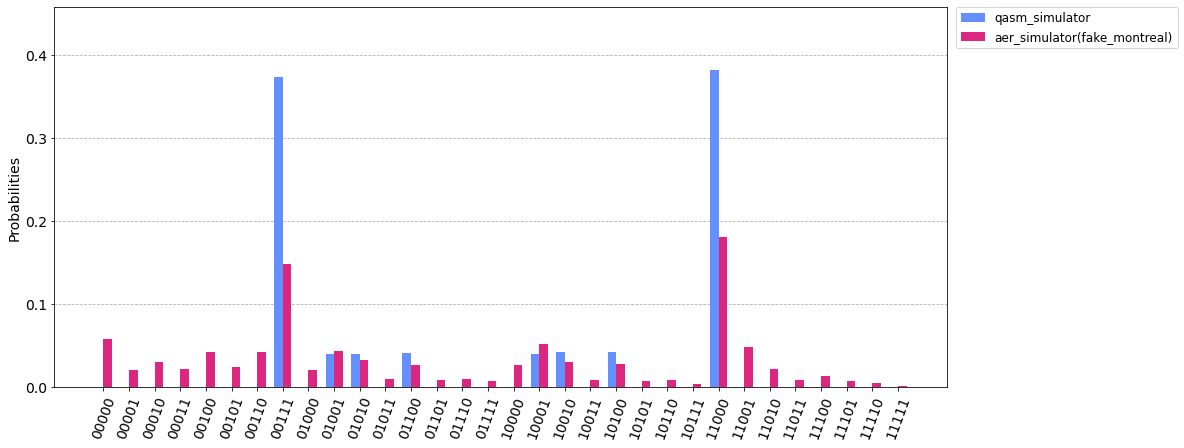

In [13]:
plot_histogram(counts_to_plot, bar_labels = False,
                   figsize = figsize,
                   legend = legend_to_plot)

In [14]:
# get an array of shape((N_gen,shots))
n_its = np.zeros((N_gen,shots)).astype(int)

# convert bitstrings to n_its and store them 

v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}

for j, bitstring in enumerate(memory):
    n_its[0][j] = v_dic[bitstring[0:2]] # Alice
    n_its[1][j] = v_dic[bitstring[2:3]] # Bob
    n_its[2][j] = v_dic[bitstring[3:4]] # Charlie
    if N_gen == 4:
        n_its[3][j] = v_dic[bitstring[4:5]] # Dave

###   check if the entangled states are not corrupt

Mutual verification that no n_it value of a list occupies the same place in one of the other lists.

Here it is not simulated because not really relevant for the demonstration.

### use the results to solve the problem

In [18]:
# define scenario

gen = { 'A': { "mat" : 0, 'name': 'Alice', 'faithful': False, 'target': None},
        'B': { "mat" : 1, 'name': 'Bob', 'faithful': True, 'target': False},
        'C': { "mat" : 2, 'name': 'Charlie', 'faithful': True, 'target': True } }
if N_gen == 4 :       
        gen['D'] = { "mat" : 3,'name': 'Dave', 'faithful': False, 'target': False} 

In [19]:
# check here the number of traitors
 
for key in list(gen.keys())[1:N_gen]:
    if not gen[key]['faithful'] and gen[key]['target']:           
        print("A lieutenant cannot be traitor himself and target of a traitorous commander") 
        print("Please correct the scenario")

traitor_counter = 0
for key in list(gen.keys())[0:N_gen]:    
    if not gen[key]['faithful']:
        traitor_counter += 1

print("Scenario with " + str(N_gen) + " generals and " + str(traitor_counter) + " traitor(s)")

if traitor_counter > N_gen -2 :
    print("No more than " + str(N_gen-2) + " traitor(s) allowed for "\
          + str(N_gen) + " generals, even with quantum power") 
    print("Please correct the scenario")    

Scenario with 4 generals and 2 traitor(s)


In [20]:
# Alice determine the message: 0 for retreat, 1 for attack
m = 1
print("Scenario run on " + backend.name())
print("generals:", list(map(lambda v: v["name"],gen.values()))[0:N_gen])
print("faithful:  ", list(map(lambda v: v["faithful"],gen.values()))[0:N_gen])
print("  target:  ", list(map(lambda v: v["target"],gen.values()))[0:N_gen])

if m == 0:
    print("Order is to attack")
else :
    print("Order is to retreat")

gen['A']['message'] = m
# Alice establishes the corresponding list of indices 
# and the corresponding cheating list

j_list_A = []
j_list_Ac = []
mat = gen['A']['mat']
for k in range(shots):
    val_it = n_its[mat:mat+1][0][k]
    if val_it == m:
        j_list_A.append(k)
    elif val_it == 1 - m:
        j_list_Ac.append(k)

# Alice send her messages and corresponding lists 
# by pairwise authenticated classical and quantum channels  

# first equalize divide lists in two, take an half and equalize lengths
random.shuffle(j_list_A)
j_list_A = j_list_A[:len(j_list_A)//2]

random.shuffle(j_list_Ac)
j_list_Ac = j_list_Ac[:len(j_list_Ac)//2]

while len(j_list_A) > len(j_list_Ac):
    j_list_A.pop()
j_list_A.sort()

while len(j_list_Ac) > len(j_list_A):
    j_list_Ac.pop()
j_list_Ac.sort()

gen['A']['j_list'] = copy.deepcopy(j_list_A) 

for key in list(gen.keys())[1:N_gen]:
    if (not gen['A']['faithful']) and gen[key]['target']:
        gen[key]['message'] = 1 - m    
        gen[key]['j_list'] = copy.deepcopy(j_list_Ac )
    else:
        gen[key]['message'] = m    
        gen[key]['j_list'] = copy.deepcopy(j_list_A) 
            
# test of consistency by the lieutenants (compare j_list and message)
for key in list(gen.keys())[1:N_gen]:
    gen[key]['flag_y'] = gen[key]['message']

# false flag by traitors:
for key in list(gen.keys())[1:N_gen]:
    if gen[key]['faithful']:
        gen[key]['t_list'] = copy.deepcopy(gen[key]['j_list'])
    else:
        gen[key]['flag_y'] = 1 - gen[key]['flag_y']
        gen[key]['t_list'] = list( set(range(shots)) - set(gen[key]['j_list']) )

# prepare for treator game

p_list = []
    
for key in list(gen.keys())[1:N_gen]:

    # add to player's list:            
    if gen[key]['flag_y'] != 3: 
        p_list.append(key)

# check if treator game possible
if len(p_list) == 1:
    print("Only one lieutenant has consistent order") 

elif len(p_list) == 0:
    print("No lieutenant has consistent order")
    
else: # treator game:
        
    res_traitor = {}
    
    for players in list(itertools.combinations(p_list, r=2)):
        
        if gen[players[0]]['flag_y'] == gen[players[1]]['flag_y']:
            print("\nNo game between " + gen[players[0]]['name']\
             + " and " + gen[players[1]]['name'] + "\nThey say they got the same order from " + gen['A']['name'])
            res_traitor[players[0] + players[1]] = -1.0
            res_traitor[players[1] + players[0]] = -1.0
        
        else:
            # prepare indices list
            for key in players:
                gen[key]['k_list'] = []                        
                mat = gen[key]['mat']
                
                for k in range(shots):
                    n_it = n_its[mat:mat+1][0][k]
                    if (k in gen[key]['t_list']) and (n_it == 1 - gen[key]['flag_y']):
                        gen[key]['k_list'].append(k)    

                    random.shuffle(gen[key]['k_list'])
                
            game_rounds, head, tail, toss = traitor_game(players, verbose_flag)
            res_traitor[players[1-toss] + players[toss]] = head / game_rounds
            res_traitor[players[toss] + players[1-toss]] = tail / game_rounds    
                
    print("\nFinal agreement:\n")
    
    sorted_res = dict(sorted(res_traitor.items()))
    res_val = list(sorted_res.values())
    test_val = np.round(np.array(res_val) + noise_dic[backend.name()])
    s_test_val = np.sum(test_val)   
    
    if N_gen == 3 :  # three generals with traitor game
                
        if s_test_val == - 2:
            print("No traitor detected")
            print("Both lieutenants follow the order of ", gen['A']['name'])
    
        elif s_test_val == 0:
            print(gen['A']['name'] + " is a traitor")
            print(gen['B']['name'] + " and " + gen['C']['name'] + " agree with a common strategy")        
        
        elif test_val[0] == [1.] and test_val[1] == [0.]:
            print(gen['C']['name'] + " is a traitor")
            print(gen['B']['name'] + " follows the order of " +  gen['A']['name'])
        
        elif test_val[0] == [0.] and test_val[1] == [1.]:
            print(gen['B']['name'] + " is a traitor")
            print(gen['C']['name'] + " follows the order of " +  gen['A']['name'])
            
        else:
            print("Something wrong")

    if N_gen == 4 :  # four generals with 1 or 2 traitors: 2 games
        
        doubtful = []
        discoverer = []
        trustable = []       
                
        for i, (j, k) in enumerate(sorted_res):
            if gen[j]['faithful'] == True:
                if test_val[i] == 1.:
                    doubtful.append(gen[k]['name'])
                    discoverer.append(gen[j]['name'])
                elif test_val[i] == 0.:
                    trustable.append(gen[k]['name'])

        if len(trustable) == 0 and len(discoverer) == 0 and len(doubtful) == 0: # No game
            print("No traitor detected")
            print("All lieutenants follow "+ gen['A']['name'] +"'s order")

        elif len(trustable) == 4 and len(discoverer) == 0 and len(doubtful) == 0: # 1C
            print(gen['A']['name'] +" is a traitor")
            print("All lieutenants follow a majority strategy")
            
        elif len(trustable) == 0 and len(discoverer) == 2 and len(doubtful) == 2: 
            
            if discoverer[0] != discoverer[1] and doubtful[0] == doubtful[1]: # 1L
                print(doubtful[0]+" is a traitor")
                print(discoverer[0]+" and "+discoverer[1]+" follow "+ gen['A']['name'] +"'s order")
            
            elif discoverer[0] == discoverer[1] and doubtful[0] != doubtful[1]: # 2L
                print(doubtful[0]+" and "+doubtful[1]+" are traitors")
                print(discoverer[0]+" follows "+ gen['A']['name'] +"'s order")
            
            else:
                print("Something wrong")
           
        elif len(trustable) == 2 and len(discoverer) == 1 and len(doubtful) == 1: #1L + 1C
                print(doubtful[0]+" and "+ gen['A']['name'] +" are traitors")
                print(trustable[0] +" and "+ trustable[1] +" agree with a common strategy")

        else:
            print("Something wrong")

Scenario run on aer_simulator(fake_montreal)
generals: ['Alice', 'Bob', 'Charlie', 'Dave']
faithful:   [False, True, True, False]
  target:   [None, False, True, False]
Order is to retreat

Byzantine traitor game. First to serve is Charlie
                        Second to serve is Bob
rounds: 500
Bob counted that Charlie failed 103 times: 21%
Charlie counted that Bob failed 60 times: 12%

Byzantine traitor game. First to serve is Bob
                        Second to serve is Dave
rounds: 500
Dave counted that Bob failed 112 times: 22%
Bob counted that Dave failed 238 times: 48%

No game between Charlie and Dave
They say they got the same order from Alice

Final agreement:

Dave and Alice are traitors
Charlie and Bob agree with a common strategy
